In [116]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [117]:
# load the dataset
df = pd.read_csv("accomplishments.csv")

# Display the first few rows of the DataFrame
df.head()

,discussion_id,title,content,datetime,user,expertise,votes,medal,n_comments,n_apppreciation_comments,...,hottest_n_replies,hottest_is_appreciation,most_voted_content,most_voted_datetime,most_voted_user,most_voted_expertise,most_voted_votes,most_voted_medal,most_voted_n_replies,most_voted_is_appreciation
0,486854,Vehicle Attributes and Emissions Dataset (Usab...,"Hello kagglers,\n\nI have recently uploaded a ...",2024-03-26 15:57:13+00:00,krupadharamshi,Contributor,3,bronze,1,0,...,0.0,False,[@krupadharamshi](https://www.kaggle.com/krupa...,2024-03-26 15:57:13+00:00,alfredkondoro,Expert,1.0,bronze,0.0,False
1,486877,Finally I became Kaggle Dataset Expert and 3Xk...,Finally I became Kaggle Dataset Expert and 3Xk...,2024-03-26 17:49:05+00:00,getanmolgupta01,Expert,0,NaN,1,0,...,0.0,False,Congrats [@getanmolgupta01](https://www.kaggle...,2024-03-26 17:49:05+00:00,anshulgupta1502,Expert,0.0,NaN,0.0,False
2,486849,I've made it to Kaggle Discussion Expert status!,I've just earned my first Expert Title on Kagg...,2024-03-26 15:30:44+00:00,anshulgupta1502,Expert,4,bronze,6,0,...,1.0,False,Congratulations [@anshulgupta1502](https://www...,2024-03-26 15:30:44+00:00,alfredkondoro,Expert,1.0,bronze,1.0,False
3,486839,First Gold in Kaggle Notebooks! 🎉,Hey Kagglers!\n\nI'm thrilled to share some ex...,2024-03-26 14:43:11+00:00,ghaithmechi,Master,7,bronze,7,0,...,0.0,False,Congratulations 🎉 upon first gold in notebook ...,2024-03-26 14:43:11+00:00,tariqbashir,Master,1.0,NaN,0.0,False
4,486848,Celebrating Top 160 Rank 🚀,**Hey Kagglers! \nI'm stoked to share that I'v...,2024-03-26 15:22:51+00:00,borhanitrash,Expert,7,bronze,8,0,...,1.0,False,Congratulations [@borhanitrash](https://www.ka...,2024-03-26 15:22:51+00:00,alfredkondoro,Expert,1.0,NaN,1.0,False


In [115]:
# Drop rows missing the 'user' or 'most_voted_user' fields
df_valid = df.dropna(subset=["user", "most_voted_user"])

# Remove rows where the discussion author replies to themselves
df_valid = df_valid[df_valid["user"] != df_valid["most_voted_user"]]

# Remove duplicates to find all unique users
unique_users = pd.unique(df_valid[["user", "most_voted_user"]].values.ravel())

# Print the number of unique users (nodes) and edges
print("Number of nodes (unique users):", len(unique_users))
print("Number of edges (replies):", len(df_valid))

Number of nodes (unique users): 156
Number of edges (replies): 319


In [ ]:
# Strip whitespace from user fields
df_valid["user"] = df_valid["user"].str.strip()
df_valid["most_voted_user"] = df_valid["most_voted_user"].str.strip()

# Remove empty usernames
df_valid = df_valid[(df_valid["user"] != "") & (df_valid["most_voted_user"] != "")]

In [110]:
# Build the directed graph (where each user is a node and each reply is a directed edge from the commenter to the discussion author)
G = nx.DiGraph()

# For each row, create a directed edge from the commenter to the discussion author (edge weight of 1 for every interaction)
for idx, row in df_valid.iterrows():
    source = row["most_voted_user"]
    target = row["user"]
    if G.has_edge(source, target):
        G[source][target]["weight"] += 1
    else:
        G.add_edge(source, target, weight=1)

In [111]:
# Degree centrality: measures how many connections each node has (both incoming and outgoing)
degree_centrality = nx.degree_centrality(G)

# Eigenvector centrality: measures influence of a node in the network
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Combine into a DataFrame
df_centrality = pd.DataFrame({
    "User": list(G.nodes()),
    "Degree_Centrality": [degree_centrality[u] for u in G.nodes()],
    "Eigenvector_Centrality": [eigenvector_centrality[u] for u in G.nodes()]
})

In [112]:
# Sort and show top users
print("\nTop Users by Degree Centrality:")
print(df_centrality.sort_values("Degree_Centrality", ascending=False).head(10))

print("\nTop Users by Eigenvector Centrality:")
print(df_centrality.sort_values("Eigenvector_Centrality", ascending=False).head(10))


Top Users by Degree Centrality:
                     User  Degree_Centrality  Eigenvector_Centrality
19             mehmetisik           0.283871                0.189881
0           alfredkondoro           0.245161                0.077681
4             tariqbashir           0.212903                0.085618
36             rabianaz22           0.141935                0.086462
24              wolfmedal           0.103226                0.349741
38            jaidalmotra           0.090323                0.134889
25   saipavankumaryedduri           0.090323                0.060832
17             mrsimple07           0.077419                0.061385
103           abdmental01           0.070968                0.177104
10              ravi20076           0.070968                0.066046

Top Users by Eigenvector Centrality:
                     User  Degree_Centrality  Eigenvector_Centrality
32   muhammadibrahimqasmi           0.064516                0.442892
16          egazakharenko       

In [ ]:
# Plotting the graph with centrality measures
def plot_graph(G, centrality_dict, title):
    plt.figure(figsize=(12, 9))
    pos = nx.spring_layout(G, seed=42)

    node_sizes = [centrality_dict[node] * 3000 for node in G.nodes()]
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray", arrows=True, arrowstyle="->", arrowsize=10)
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title(title)
    plt.axis("off")
    plt.show()

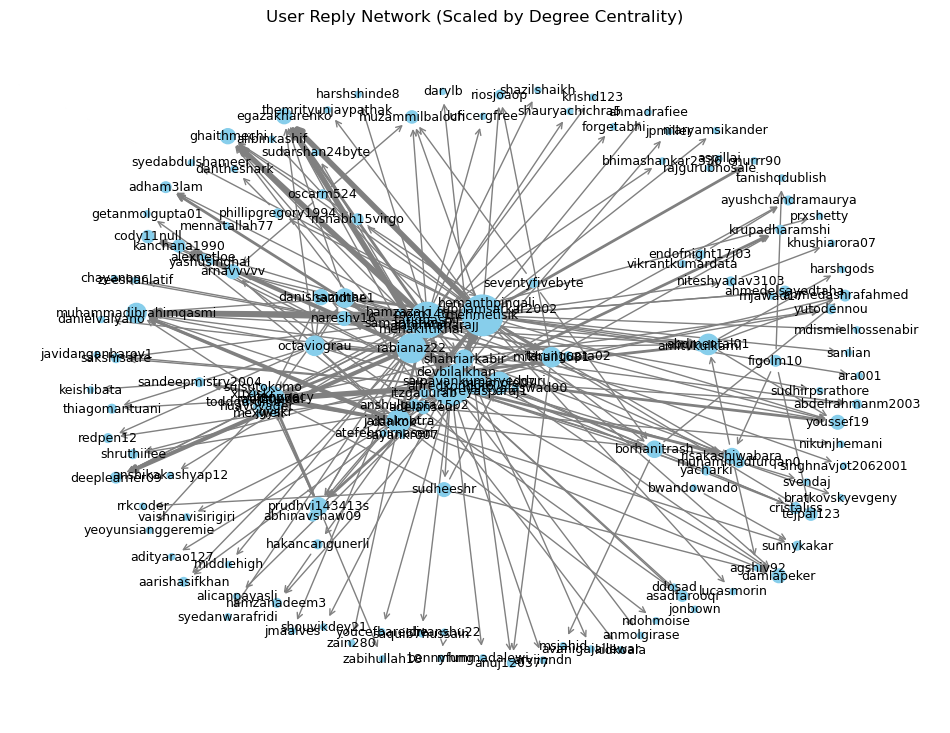

In [107]:
plot_graph(G, degree_centrality, "User Reply Network (Scaled by Degree Centrality)")

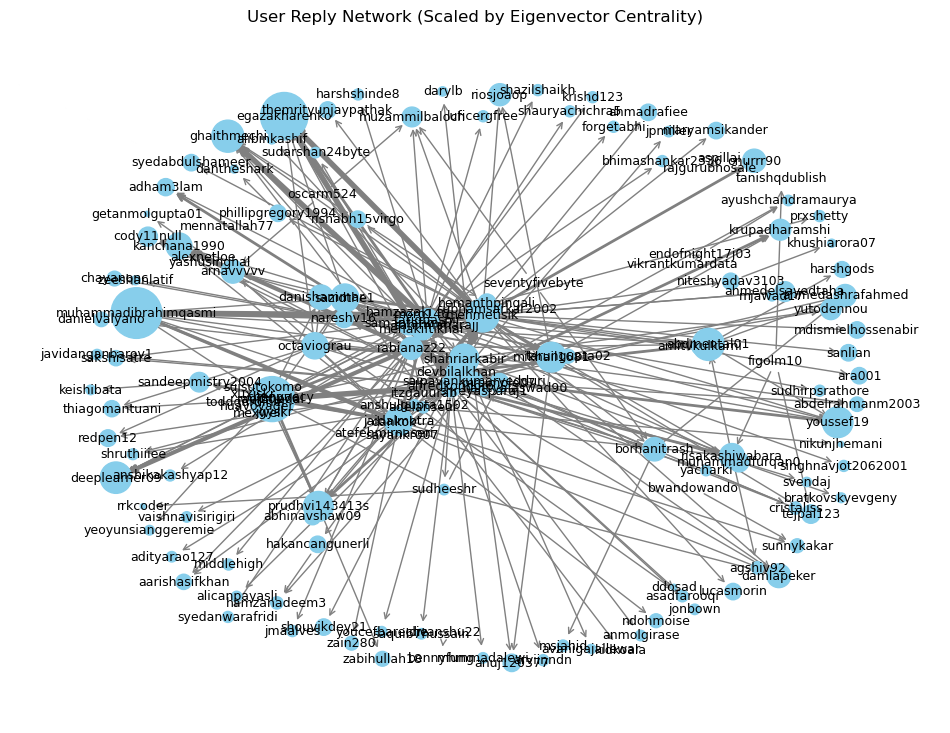

In [108]:
plot_graph(G, eigenvector_centrality, "User Reply Network (Scaled by Eigenvector Centrality)")